In [1]:
import pandas as pd
import numpy as np
import xarray
from pyeosim.spectral import TreeView_3
import seaborn
import matplotlib.pyplot as plt

In [2]:
tv3 = TreeView_3()
radiance = xarray.load_dataarray('sensor_radiance.nc')

In [3]:
def load_solar_E(fpath='solar_irradiance/e490_00a_amo.xls'):
    f = pd.read_excel(fpath)
    wlen_u = f.iloc[:, 0].values * 1000
    E_wm2u = f.iloc[:, 1].values / 1000
    return xarray.DataArray(
        E_wm2u,
        coords={'wavelength': wlen_u}).sel(wavelength=slice(280, 3000))

def _rho_s(rho_toa, rho_r, S_atm, T_s, T_v):
    return (rho_toa - rho_r) / (S_atm * (rho_toa - rho_r) + (T_s * T_v))

def _mu_s(solar_z):
    return np.cos(np.deg2rad(solar_z))

def _mu_v(solar_a):
    return np.cos(np.deg2rad(solar_a))

def _d(day_of_year):
        # solar distance in AUs
        return 0.03275104 * np.cos(day_of_year / 59.66638337) + 0.96804905

def _rho_toa(L, d, spectral_response,
             mu_s, solar_spectrum):
    # generate per- band E_sun
    E_sun = spectral_response.transform(solar_spectrum)
    return (np.pi * L * d**2) / (E_sun * mu_s)

def _rho_r(P_r, M, mu_s, mu_v, tau_r):
    
    return P_r * ((1-np.exp(-M * tau_r)) / (4 * (mu_s + mu_v)))

def _M(mu_s, mu_v):
    return (1/mu_s) + (1/mu_v)

def _tau_r(spectral_response):
    C0 = 0.008569
    C1 = 0.0113
    C2 = 0.0013
    tau_r = []
    for wlen in spectral_response.band_wavelengths.values():
        # keep as nm for now but might need to be changed to m
        lam = wlen
        tau_r.append(C0 * (lam**-4) * (1+ (C1 * (lam ** -2)) + (C2 * (lam ** -1))))
    return xarray.DataArray(tau_r, coords={'band':np.arange(len(tau_r))})

def _P_r(Theta):
    A = 0.9587256
    B = 1 - A
    return ((3 * A) / 4 + B) * (1+(np.cos(np.deg2rad(Theta)) **2))

def _S_atm(tau_r):
    return (0.92 * tau_r) * np.exp(-tau_r)

def _T_s(mu_s, tau_r):
    return np.exp((-tau_r) / mu_s) + (np.exp((-tau_r) / mu_s) * (np.exp((0.52 * tau_r) / mu_s) -1))

def _T_v(mu_v, tau_r):
    return np.exp((-tau_r) / mu_v) + (np.exp((-tau_r) / mu_v) * (np.exp((0.52 * tau_r) / mu_v) -1))

def correct(L, spectral_response, solar_z,
            solar_a, scattering_angle,
            day_of_year, solar_spectrum):
    
    mu_s = _mu_s(solar_z)
    mu_v = _mu_v(solar_a)
    d = _d(day_of_year)
    rho_toa = _rho_toa(L, d, spectral_response, mu_s, solar_spectrum)
    M = _M(mu_s, mu_v)
    tau_r = _tau_r(spectral_response)
    P_r = _P_r(scattering_angle)
    S_atm = _S_atm(tau_r)
    T_s = _T_s(mu_s, tau_r)
    T_v = _T_v(mu_v, tau_r)
    rho_r = _rho_r(P_r, M, mu_s, mu_v, tau_r)
    rho_s = _rho_s(rho_toa, rho_r, S_atm, T_s, T_v)
    return rho_s

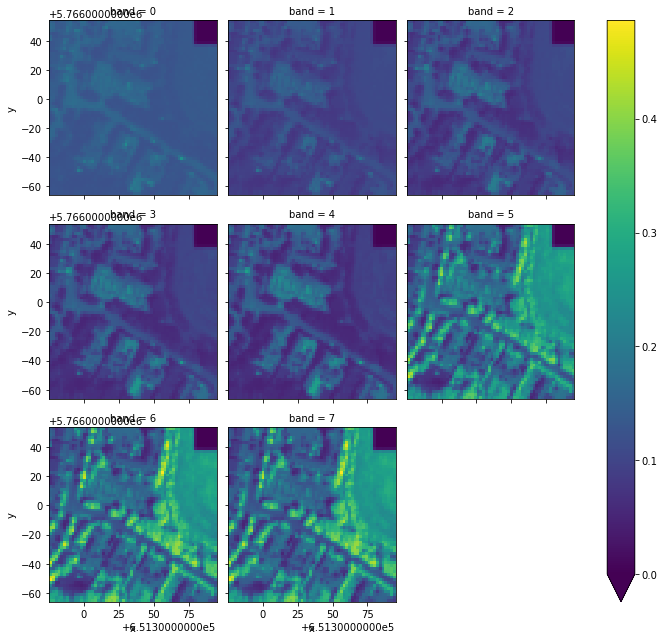

In [4]:
truth = xarray.load_dataarray('sensor_equiv_reflectance.nc')
dark_region_mask = xarray.zeros_like(truth.isel(band=0)).astype(bool)
dark_region_mask[50:60, 50:60] = 1

bw = xarray.DataArray(
    [20, 50, 50, 40, 40, 14, 14, 30],
    coords={'band': np.arange(8)}
)

corrected = correct(radiance, tv3, 33, 140, 146.7, 173,  load_solar_E())
corrected.plot(col='band', vmin=0, col_wrap=3, size=3)

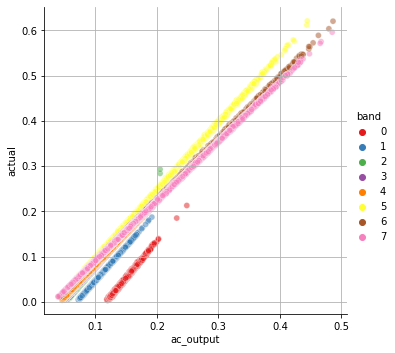

In [5]:
obs = corrected.where(~dark_region_mask)
obs_df = obs.stack({'pix': ['y', 'x']}).to_dataframe(name='ac_output')

exp = truth.where(~dark_region_mask)
exp_df = exp.stack({'pix': ['y', 'x']}).to_dataframe(name='expected')

obs_df['actual'] = exp_df['expected']
seaborn.relplot(data=obs_df,
                x='ac_output',
                y='actual',
                hue='band',
                palette='Set1',
                alpha=.5)
plt.grid()

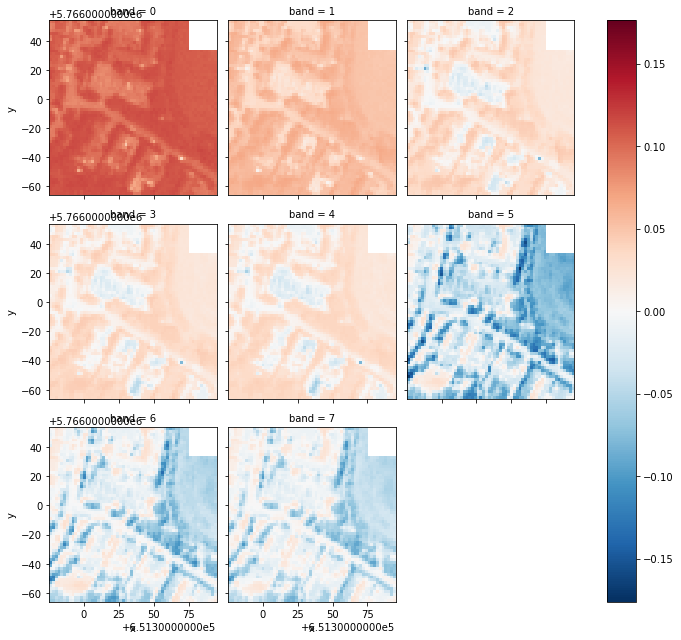

In [6]:
(obs - truth).plot(col='band', col_wrap=3)